## Comparison of Support Vector Machines and Decision Trees (Section 6.5)
* Zweck: Berechnen der Resultate der Section "Comparison with Decision Trees" aus dem Kapitel Results. Das erste Script zeigt die Laufzeitunterschiede und das Zweite die Präzisionsunterschiede in der Klassifikation.

### Laufzeitunterschiede
* Matrix: Teile einer Klassifikationsmatrix auf aktuellem Stand "current" des mozilla-central Repository
* Features: Includes
* Modell: Support Vector Machine Classifier, Decision Tree Classifier

#### Setup
* Matrix: Die Matrix wird bei jedem Schritt um 10% vergrössert (10%-100%)
* Training-Set/Test-Set: Stratified sampling auf der Matrix (2/3 : 1/3)

#### Results
Das Skript trainiert je einen SVM- und einen DT-Classifier mit fortlaufend grösseren Training-Sets und berechnet anschliessend Precision und Recall. Die Zeit, die für das Trainieren benötigt wird, ist im Plot dargestellt.

DT                  : 20/20
SVM                 : 20/20


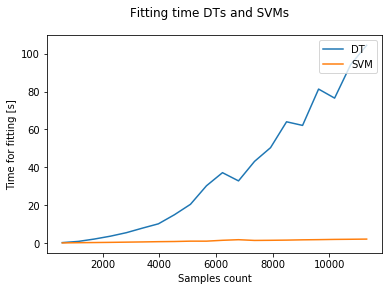

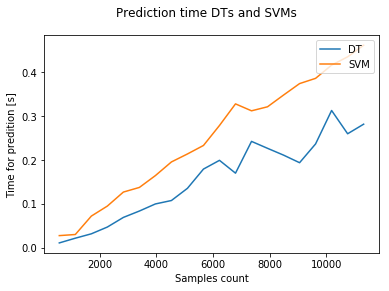

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from imports.matrix_helper import MatrixHelper
from imports.prediction_helper import PredictionHelper
from sklearn.metrics import precision_recall_curve

matrix_helper = MatrixHelper()

# Read pickle
matrices = matrix_helper.load_from_parse('data/matrices/matrix_cla_incl_current.pickle')

experiments_count = 20
models = [('DT', 'DT'), ('LinearSVC', 'SVM')]
time_fitting_lists = {}
time_predicting_lists = {}
relevant_samples = []

for implementation, model in models:
    time_fitting_lists[model] = []
    time_predicting_lists[model] = []
    
    for i in range(experiments_count):
        print '{:20}: {:2}/{:2}\r'.format(model, i+1, experiments_count),
        relevant = int((matrices[0].shape[0] / float(experiments_count)) * (i + 1))
        # Instantiate Prediction Helper Class and calculate prediction
        prediction_helper = PredictionHelper()
        prediction_helper.calculate_validation_compare_matrix(matrices, sampling_factor=(2.0/3), model_type=implementation, crop_matrix=relevant)
        compare_matrix = prediction_helper.get_compare_matrix()

        # Compute Precision-Recall
        precision, recall, thresholds = precision_recall_curve(np.array(compare_matrix[:, 2], dtype='f'), np.array(compare_matrix[:, 1], dtype='f'))
        
        time_fitting_lists[model].append(prediction_helper.time_fitting)
        time_predicting_lists[model].append(prediction_helper.time_predicting)
        
        if model == 'DT':
            relevant_samples.append((2.0/3) * relevant)
    print

# plot
figure_time_fitting = plt.figure()

plt.xlabel('Samples count')
plt.ylabel('Time for fitting [s]')
figure_time_fitting.suptitle('Fitting time DTs and SVMs')
for implementation, model in models:
    plt.plot(relevant_samples, time_fitting_lists[model], label=model)
plt.legend(loc=1)


figure_time_predicting = plt.figure()

plt.xlabel('Samples count')
plt.ylabel('Time for predition [s]')
figure_time_predicting.suptitle('Prediction time DTs and SVMs')
for implementation, model in models:
    plt.plot(relevant_samples, time_predicting_lists[model], label=model)
plt.legend(loc=1)


figure_time_fitting.savefig('outputs/dt-vs-svm-time_fitting.pdf')
figure_time_predicting.savefig('outputs/dt-vs-svm-time_predicting.pdf')

### Präzisionsunterschiede in der Klassifikation
* Matrix: Klassifikationsmatrix auf aktuellem Stand "current" des mozilla-central Repository
* Features: Includes
* Modell: Support Vector Machine Classifier, Decision Tree Classifier

#### Setup
* Training-Set/Test-Set: Stratified sampling auf der Matrix (2/3 : 1/3)

#### Results
Das Skript trainiert 40 mal je einen SVM- und einen DT-Classifier und berechnet eine Vorhersage. Precision und Recall sind im Scatterplot und in der Tabelle dargestellt.

DT                  : 40/40
SVM                 : 40/40
+------------------------------------+
| Average of  40 Experiments:        |
+------------+-----------+--------+------------------+
| Classifier | Precision | Recall | time for fitting |
+------------+-----------+--------+------------------+
| DT         |    0.46   |  0.38  |     1.78min      |
| SVM        |    0.68   |  0.35  |     0.04min      |
+------------+-----------+--------+------------------+


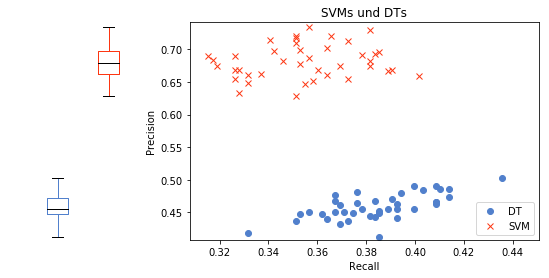

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from imports.matrix_helper import MatrixHelper
from imports.prediction_helper import PredictionHelper
from sklearn.metrics import precision_recall_curve
from prettytable import PrettyTable

matrix_helper = MatrixHelper()
experiments_count = 40

models = [('DT', 'DT', 'o', '#5180cc'), ('LinearSVC', 'SVM', 'x', '#FD3612')]
precision_lists = {}
recall_lists = {}
time_lists = {}

for model in models:
    # Read pickle
    matrices = matrix_helper.load_from_parse('data/matrices/matrix_cla_incl_current.pickle')
    precision_lists[model[0]] = []
    recall_lists[model[0]] = []
    time_lists[model[0]] = []
    
    for i in range(experiments_count):
        print '{:20}: {:2}/{:2}\r'.format(model[1], i+1, experiments_count),
        # Instantiate Prediction Helper Class and predict values for compare matrix with an SVM
        prediction_helper = PredictionHelper()
        prediction_helper.calculate_validation_compare_matrix(matrices, sampling_factor=(2.0/3), model_type=model[0])
        compare_matrix = prediction_helper.get_compare_matrix()

        # Compute Precision-Recall
        precision, recall, thresholds = precision_recall_curve(np.array(compare_matrix[:, 2], dtype='f'), np.array(compare_matrix[:, 1], dtype='f'))

        precision_lists[model[0]].append(precision[1])
        recall_lists[model[0]].append(recall[1])
        time_lists[model[0]].append(prediction_helper.time_fitting)
    print

# plot
ymin = min([min(precision_lists[list]) for list in precision_lists])
ymax = max([max(precision_lists[list]) for list in precision_lists])

fig = plt.figure(figsize=(9, 4))

for i, model in enumerate(models):
    ax = plt.subplot2grid((1, 10), (0, i))
    boxprops = dict(color=model[3])
    flierprops = dict(markerfacecolor=model[3],markeredgecolor=model[3], marker=model[2])
    whiskerprops = dict(color=model[3])
    medianprops = dict(color='black')
    plt.boxplot(precision_lists[model[0]], flierprops=flierprops, whiskerprops=whiskerprops, boxprops=boxprops, medianprops=medianprops, widths=(0.5))
    plt.ylim(ymin=ymin/1.01, ymax=ymax*1.01)
    plt.axis('off')

ax = plt.subplot2grid((1, 10), (0, 3), colspan=7)
for model in models:
    plt.scatter(recall_lists[model[0]], precision_lists[model[0]], edgecolor=model[3], linewidth='1', facecolor=model[3], marker=model[2], label=model[1])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(ymin=ymin/1.01, ymax=ymax*1.01)
plt.legend(loc=4)
ax.set_title('SVMs und DTs')

fig.savefig('outputs/dt-vs-svm-precision-reacall.pdf')



# create table
table = PrettyTable(['Classifier', 'Precision', 'Recall', 'time for fitting'])
table.align["Classifier"] = "l"

for model in models:
    precision_average = "{:.2f}".format(sum(precision_lists[model[0]]) / float(len(precision_lists[model[0]])))
    recall_average = "{:.2f}".format(float(sum(recall_lists[model[0]])) / len(recall_lists[model[0]]))
    time_average = "{:.2f}min".format((float(sum(time_lists[model[0]])) / len(time_lists[model[0]])) / 60.0)
    table.add_row([model[1], precision_average, recall_average, time_average])

# print
print('+------------------------------------+')
print('| Average of {:3} Experiments:        |'.format(experiments_count))
print(table)
